In [368]:
chrom = '22'
family_sizes = [3, 4, 5]
phase_dir = '../phased_unknown_cutoff'
data_dir = '../split_gen_miss'


In [306]:
ped_files = ['../data/160826.ped', '../data/ssc.ped']
# Affection (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()

for ped_file in ped_files:
    with open(ped_file, 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            if len(pieces) >= 6:
                fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
                child_id_to_affected[child_id] = disease_status
                child_id_to_sex[child_id] = sex

In [307]:
# From GRCh37.p13 https://www.ncbi.nlm.nih.gov/grc/human/data?asm=GRCh37.p13
chrom_lengths = {
	'1': 249250621,
	'2': 243199373,
	'3': 198022430,
	'4': 191154276,
	'5': 180915260,
	'6': 171115067,
	'7': 159138663,
	'8': 146364022,
	'9': 141213431,
	'10': 135534747,
	'11': 135006516,
	'12': 133851895,
	'13': 115169878,
	'14': 107349540,
	'15': 102531392,
	'16': 90354753,
	'17': 81195210,
	'18': 78077248,
	'19': 59128983,
	'20': 63025520,
	'21': 48129895,
	'22': 51304566,
	'X': 155270560,
	'Y': 59373566
}
chrom_length = chrom_lengths[chrom]


In [308]:
# Pull cytogenetic coordinates
with open('../data/cytoBand.txt', 'r') as f:
    xticks, xticklabels = [], []
    for line in f:
        pieces = line.strip().split()
        if pieces[0] == 'chr%s' % chrom:
            xticks.append(int(pieces[1]))
            xticklabels.append(pieces[3])

In [309]:
# pull families with sequence data
sample_file = '%s/chr.%s.gen.samples.txt' % (data_dir, chrom)
with open(sample_file, 'r') as f:
    sample_ids = [line.strip() for line in f]
sample_id_to_index = dict([(sample_id, i) for i, sample_id in enumerate(sample_ids)])

In [310]:
from scipy import sparse
from os import listdir

# pull genotype data from .npz
gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s' % chrom) in f and 'gen.npz' in f])
whole_chrom = sparse.hstack([sparse.load_npz('%s/%s' % (data_dir, gen_file)) for gen_file in gen_files])
#whole_chrom = whole_chrom[:, snp_indices]

total_inds, n = whole_chrom.shape
print('chrom shape', total_inds, n)

chrom shape 4610 1096535


In [369]:
del_pos = set()
for j in family_sizes:
    # load deletions
    with open('%s/chr.%s.familysize.%d.phased.txt' % (phase_dir, chrom, j), 'r')  as f:
        next(f) # skip header
        for line in f:
            pieces = line.strip().split('\t')
            start_pos, end_pos = [int(x) for x in pieces[(2+(j*2)):(4+(j*2))]]
            del_pos.add(start_pos)
            del_pos.add(end_pos)
del_pos = np.asarray(sorted(del_pos), dtype=int)
pos_to_index = dict([(x, i) for i, x in enumerate(del_pos)])

In [370]:
from collections import defaultdict

# load deletions from all chromosomes
deletions = -np.ones((whole_chrom.shape[0], len(del_pos), 2), dtype=np.int8)
unmodeled = -np.ones((whole_chrom.shape[0], len(del_pos)))
inheritance = -np.ones((whole_chrom.shape[0], len(del_pos), 2), dtype=np.int8)
family_to_individuals = dict()

fams = set()
for j in family_sizes:
    with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r')  as f:
        next(f) # skip header
        num_fams_of_size = 0
        for line in f:
            pieces = line.strip().split('\t')
            family_key = pieces[0]
            family_to_individuals[family_key] = pieces[1:(1+j)]
            fams.add(family_key)
            num_fams_of_size += 1
        print('%d families of size %d' % (num_fams_of_size, j))
                
    # load deletions
    with open('%s/chr.%s.familysize.%d.phased.txt' % (phase_dir, chrom, j), 'r')  as f:
        next(f) # skip header
        for line in f:
            pieces = line.strip().split('\t')
            family_key = pieces[0]
            inheritance_state = [int(x) for x in pieces[1:(2+(j*2))]]
            start_pos, end_pos = [int(x) for x in pieces[(2+(j*2)):(4+(j*2))]]
            start_index, end_index = pos_to_index[start_pos], pos_to_index[end_pos]
            length = end_pos - start_pos + 1
            individuals = family_to_individuals[family_key] 
            
            unmodeled[[sample_id_to_index[x] for x in individuals], start_index:(end_index+1)] = inheritance_state[-1]

            # children
            for k, child_id in enumerate(individuals[2:]):
                mat, pat = inheritance_state[(4+(2*k)):(6+(2*k))]
                
                inheritance[sample_id_to_index[child_id], start_index:(end_index+1), 0] = mat
                inheritance[sample_id_to_index[child_id], start_index:(end_index+1), 1] = pat
                
                mat_del, pat_del = None, None
                if mat >= 0 and inheritance_state[mat] >= 0:
                    mat_del = inheritance_state[mat]==0
                elif mat == -1 and inheritance_state[0] == inheritance_state[1] and inheritance_state[0] >= 0:
                    mat_del = inheritance_state[0]==0
                    
                if pat >= 0 and inheritance_state[2+pat] >= 0:
                    pat_del = inheritance_state[2+pat]==0
                elif pat == -1 and inheritance_state[2] == inheritance_state[3] and inheritance_state[2] >= 0:
                    pat_del = inheritance_state[2]==0
                       
                if mat_del is not None:
                    if mat_del:
                        deletions[sample_id_to_index[child_id], start_index:(end_index+1), 0] = 1
                    else:
                        deletions[sample_id_to_index[child_id], start_index:(end_index+1), 0] = 0
                        
                if pat_del is not None:
                    if pat_del:
                        deletions[sample_id_to_index[child_id], start_index:(end_index+1), 1] = 1
                    else:
                        deletions[sample_id_to_index[child_id], start_index:(end_index+1), 1] = 0
                
            # decide how many deletions mom and dad have
            mom_del, dad_del = None, None
            if inheritance_state[0] == 0 or inheritance_state[1] == 0:
                deletions[sample_id_to_index[individuals[0]], start_index:(end_index+1), 0] = 1
            if inheritance_state[2] == 0 or inheritance_state[3] == 0:
                deletions[sample_id_to_index[individuals[1]], start_index:(end_index+1), 1] = 1
                
print('Chrom', chrom, 'total families', len(fams))

18 families of size 3
436 families of size 4
167 families of size 5
Chrom 22 total families 621


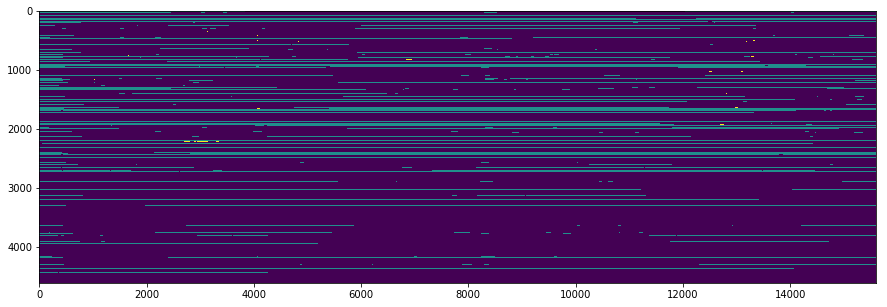

In [371]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.imshow(deletions[:, :, 0], aspect='auto', vmin=-1, vmax=1)
plt.show()

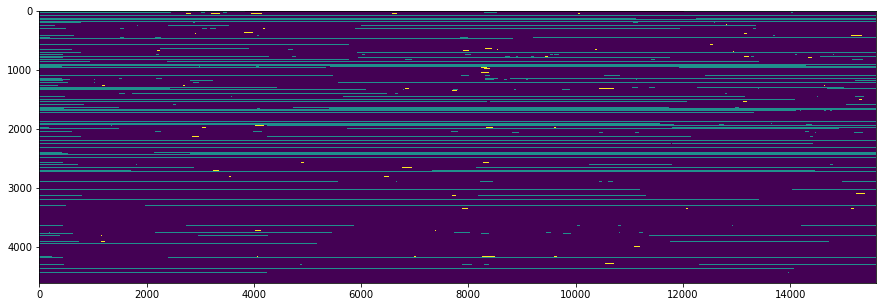

In [373]:
plt.figure(figsize=(15, 5))
plt.imshow(deletions[:, :, 1], aspect='auto', vmin=-1, vmax=1)
plt.show()

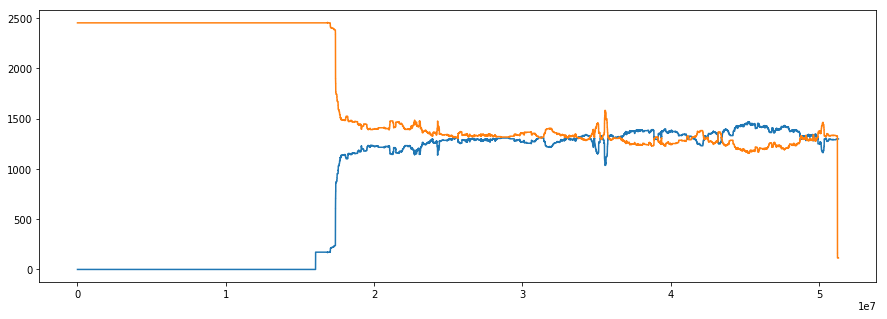

In [374]:
plt.figure(figsize=(15, 5))
plt.plot(del_pos, np.sum(unmodeled[:, :]==0, axis=0))
plt.plot(del_pos, np.sum(unmodeled[:, :]==1, axis=0))

plt.show()

In [357]:
import random

#family = ('AU0033', 'AU003301', 'AU003302')
#family = ('AU1549', 'AU1549202', 'AU1549201')
#family = ('AU0941', 'AU0941202', 'AU0941201')
# 'AU062501', 'AU062502' deletion in mom and dad

individuals = family_to_individuals['.'.join(family)]  

famkey, individuals = random.choice(list([(k, v) for k, v in family_to_individuals.items()]))
family_indices = [sample_id_to_index[x] for x in individuals]
print(individuals)
print([child_id_to_sex[x] for x in individuals])
print([child_id_to_affected[x] for x in individuals])


['AU080901', 'AU080902', 'AU080905', 'AU080904', 'AU080903']
['2', '1', '2', '1', '1']
['1', '1', '2', '2', '1']


In [367]:
print(famkey)

AU0809.AU080901.AU080902


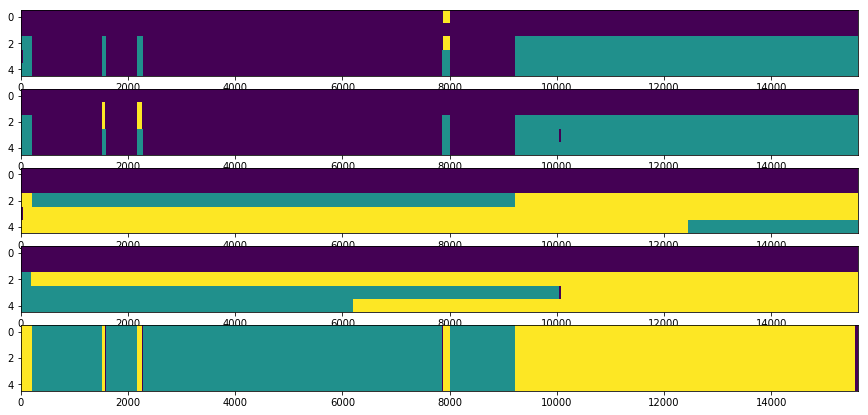

In [375]:
plt.figure(figsize=(15, 7))
plt.subplot(5, 1, 1)
plt.imshow(deletions[family_indices, :, 0], aspect='auto', vmin=-1, vmax=1)
plt.subplot(5, 1, 2)
plt.imshow(deletions[family_indices, :, 1], aspect='auto', vmin=-1, vmax=1)
plt.subplot(5, 1, 3)
plt.imshow(inheritance[family_indices, :, 0], aspect='auto', vmin=-1, vmax=1)
plt.subplot(5, 1, 4)
plt.imshow(inheritance[family_indices, :, 1], aspect='auto', vmin=-1, vmax=1)
plt.subplot(5, 1, 5)
plt.imshow(unmodeled[family_indices, :], aspect='auto', vmin=-1, vmax=1)
plt.show()

In [364]:
famdel = deletions[family_indices, :]
starts = np.where(((famdel[0, 1:, 0]==1) & (famdel[0, :-1, 0]!=1)) | ((famdel[1, 1:, 1]==1) & (famdel[1, :-1, 1]!=1)))[0]
ends = np.where(((famdel[0, 1:, 0]!=1) & (famdel[0, :-1, 0]==1)) | ((famdel[1, 1:, 1]!=1) & (famdel[1, :-1, 1]==1)))[0]
print(starts)
print(ends)

[ 988 1701]
[1008 1826]


In [365]:
famgen = whole_chrom[family_indices, :].A

21006415 21287910 281495


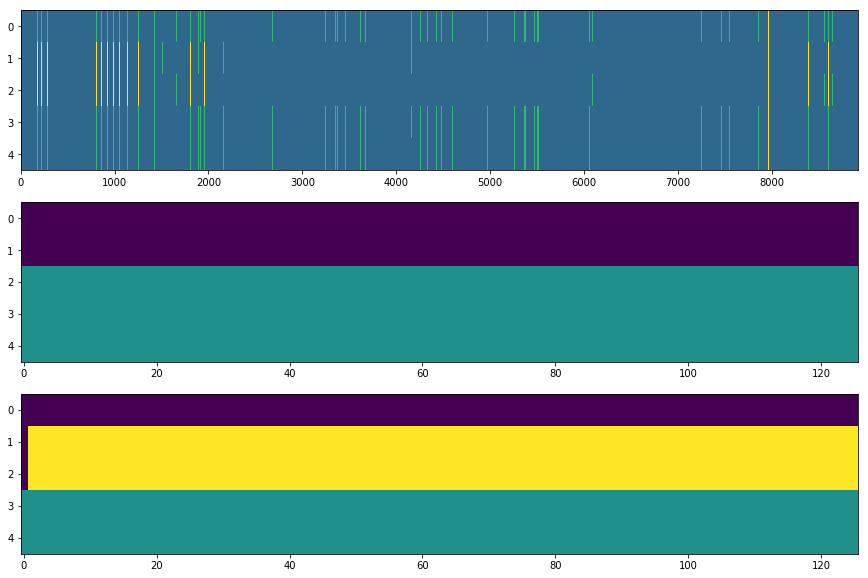

In [366]:
# 31734011 31989435 255424 either bad phasing or de novo deletion
# 104408027 104529672 121645 who knows?

start, end = random.choice(list(zip(starts, ends)))
start_pos, end_pos = del_pos[start], del_pos[end]
print(start_pos, end_pos, end_pos-start_pos)

plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.imshow(famgen[:, (snp_positions>=start_pos) & (snp_positions<=end_pos) & np.all(famgen>=0, axis=0)], aspect='auto', vmin=-1, vmax=2)

plt.subplot(3, 1, 2)
plt.imshow(famdel[:, (del_pos>=start_pos) & (del_pos<=end_pos), 0], aspect='auto', vmin=-1, vmax=1)

plt.subplot(3, 1, 3)
plt.imshow(famdel[:, (del_pos>=start_pos) & (del_pos<=end_pos), 1], aspect='auto', vmin=-1, vmax=1)

plt.show()


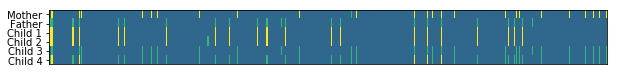

In [243]:
plt.figure(figsize=(10, 1))

plt.imshow(famgen[:, (snp_positions>=start_pos) & (snp_positions<=end_pos) & np.all(famgen>=0, axis=0)], aspect='auto', vmin=-1, vmax=2)
plt.yticks(range(6), ['Mother', 'Father', 'Child 1', 'Child 2', 'Child 3', 'Child 4'])
plt.xticks([])
plt.show()